# CSP Features 

### Steps of FB-CSP Classification 
(Fast EEG-Based Decoding Of The Directional Focus Of Auditory Attention Using Common Spatial Patterns)
- Step 1: Filter Bank
    - 14(B is number of filter bank) 8th-order butterworth filters. The first filter corresponds to frequency band 1-4 hz. The second with 2-6. And continuous with overlap 2 hz until 26(2+12*2)-30 hz. 
    - Downsample to 64 hz. (先不做)
- Step 2: CSP
    - How to choice the filter? RMOE (in this paper) vs. Covariance (mne, or common methods)
    - Choice k components from CSP filter
- Step 3: Log Energy
    - Summation the CSP pattern and calculate the log energy of every band and k filters
    - Output feature: Filter Bank B x k components
    - This step will be done by mne.decoding.csp.
- Step 4: Classification
    - 

### Data pipline or workflow
Theres two task of the works. Binary classification vs. Multi-class
First in single classes
- Data Prepration: 
    - Input Data: 2(class) x 25(subjects) x 32/2(trials, unknown?) x channel num x trials timepoint
    - Output Data: channel num x 2(class) x segments numbers[subjects x trials x decision windows numbers] x decision windows size (4sec x 128hz)
- Step 1: Filter Bank
    - Input Data: (channel num, 2 x segments numbers, 512)
    - Ouput Data: 2, segments numbers, 14 bank num, 512
- Step 2: CSP
    - Input Data: (s)

### Step 1 - Data Prepration

In [44]:
import mne
import h5py
import numpy as np

# Parameters
class_ = 2
subjects = 2
trials = 4
fs = 128  # sampling frequency
window_sec = 4
window_size = fs * window_sec  # 512
channels = 32  # assume full 32 channels
min_len = 6400
max_len = 10240

# Simulate data
all_segments = []
all_labels = []

for class_num in range(class_):
    for subj in range(subjects):
        for trial in range(trials):
            # Random trial length
            trial_len = np.random.randint(min_len, max_len)
            
            # Simulate multichannel EEG: shape = (channels, trial_len)
            data = np.random.randn(channels, trial_len) * 1e-6
            
            # Segment into 4-second windows (non-overlapping)
            n_windows = trial_len // window_size
            
            for win in range(n_windows):
                segment = data[:, win * window_size : (win + 1) * window_size]  # shape: (channels, 512)
                all_segments.append(segment)
                all_labels.append(class_num)

# Convert to numpy arrays
X = np.stack(all_segments)  # shape: (total_segments, channels, 512)
y = np.array(all_labels)    # shape: (total_segments,)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

n_epochs, n_channels, n_times = X.shape
sfreq = 128  # sampling frequency

# 建立 channel info
# 你給的通道名稱
ch_names = [
    'Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
    'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 建立 event array
# MNE 的 events shape 是 (n_epochs, 3)，通常中間值無用
# 最後一欄是 class label，需要轉換成 event id 後對應 dict
events = np.column_stack((
    np.arange(len(y)),  # arbitrary sample indices
    np.zeros(len(y), dtype=int),  # filler
    y
))

# 建立 event_id 字典
event_id = {f'class_{i}': i for i in np.unique(y)}

# 轉成 EpochsArray
epochs = mne.EpochsArray(X, info, events=events, event_id=event_id, verbose=False)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

# 檢查一下
print(epochs)
# epochs.plot(n_epochs=5, n_channels=10)

Data shape: (237, 32, 512)
Labels shape: (237,)
<EpochsArray | 237 events (all good), 0 – 3.992 s (baseline off), ~29.7 MB, data loaded,
 'class_0': 121
 'class_1': 116>


### Step 2 - CSP and Log Power

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 7.8e-07 (2.2e-16 eps * 32 dim * 1.1e+08  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32


[Parallel(n_jobs=1)]: Done 7584 out of 7584 | elapsed:    1.2s finished


Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.


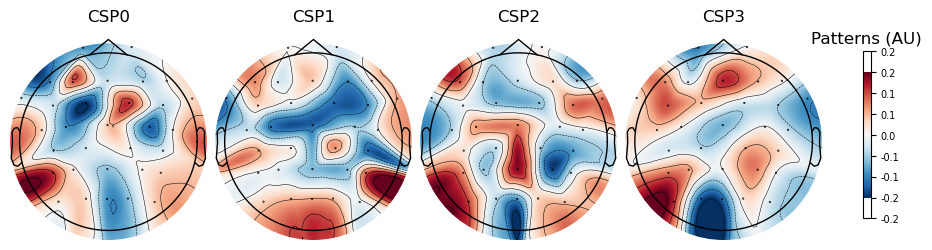

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 32 dim * 2e+08  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors


[Parallel(n_jobs=1)]: Done 7584 out of 7584 | elapsed:    0.7s finished


Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.


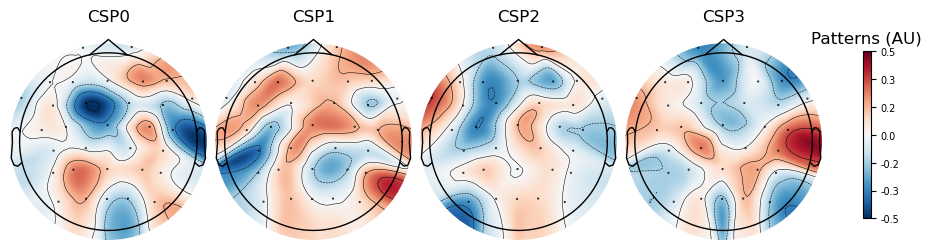

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 57 samples (0.445 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 32 dim * 2.1e+08  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32


[Parallel(n_jobs=1)]: Done 7584 out of 7584 | elapsed:    1.6s finished


Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.


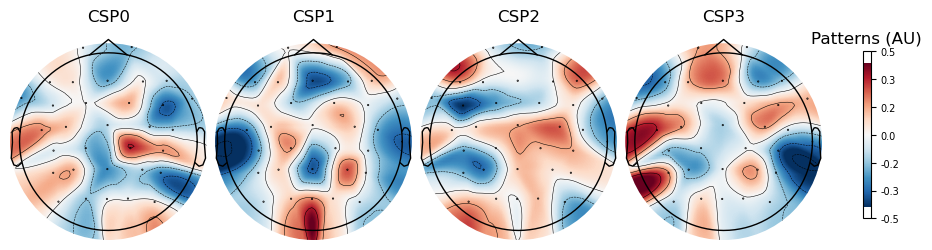

In [47]:
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

bands = {
    'alpha': (8, 12),
    'beta': (13, 30),
    'gamma': (30, 45)
}
all_features = []

for name, (l_freq, h_freq) in bands.items():
    # Band-pass filter
    epochs_band = epochs.copy().filter(l_freq, h_freq, fir_design='firwin')

    # Fit CSP on this band
    csp = CSP(n_components=4, reg='ledoit_wolf')
    X_csp = csp.fit_transform(epochs_band.get_data(), y)  # labels: array of class labels
    csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
    # Transform data to CSP space
    # X_csp = csp.transform(epochs_band.get_data())  # shape: (n_trials, n_components)

    all_features.append(X_csp)

CSP_features = np.concatenate(all_features, axis=1)


### Step 3 - Classification

Classification accuracy: 0.9416666666666668 / Chance level: 0.510548523206751


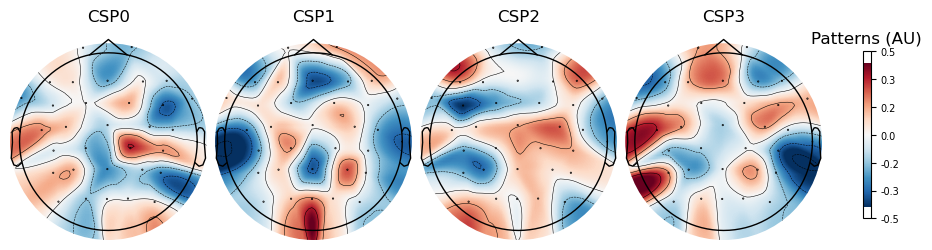

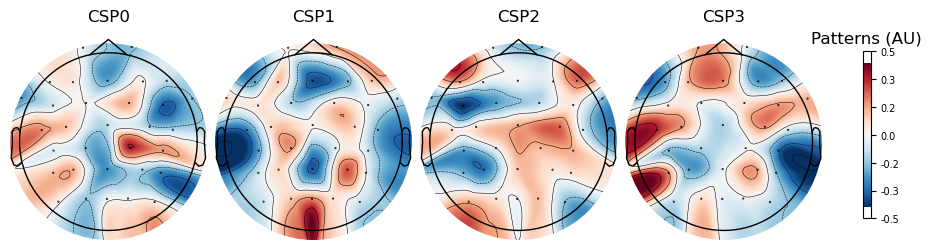

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(CSP_features)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
svc = svm.SVC()

scores = cross_val_score(svc, CSP_features, y, cv=cv_split, n_jobs=None)

# Printing the results
class_balance = np.mean(y == y[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
# csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)